In [16]:
import bclr
import ruptures as rpt
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy.stats import multivariate_normal, binom
import matplotlib.pyplot as plt
import pandas as pd
import changeforest
from sklearn.linear_model import LogisticRegression

pf = PolynomialFeatures(include_bias=False)
ss = StandardScaler()

Multiple changepoint demo

In [27]:
n, dim = 500, 3  # number of samples, dimension
n_bkps, sigma = 5, 5  # number of change points, noise standard deviation
signal, bkps = rpt.pw_constant(n, dim, n_bkps, noise_std=sigma)
prior_cov=np.diag(np.repeat(2, 3))
bclrM = bclr.MultiBayesCC(signal, cps=5, prior_cov=prior_cov, n_iter=1000, min_size=50)
bclrM.warm_up(random_init=True, reps=5)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


In [12]:
print(bkps[:-1])

[87, 169, 255, 337, 424]


In [30]:
bclrM.fit()

In [31]:
bclrM.transform()
bclrM.cps_df()

,Location,Posterior Probability,Normalized Entropy
0,92.0,0.306,0.378534
1,176.0,0.374,0.337034
2,255.0,0.348,0.314673
3,335.0,0.324,0.392660
4,421.0,0.336,0.387900


### Correctly identifies the changes in each coordinate!!!

In [15]:
[np.mean(bc.post_beta > 0, axis=0) for bc in bclrM.bccs_]

[array([0., 1., 0.]),
 array([1.   , 0.772, 0.696]),
 array([0.   , 1.   , 0.782]),
 array([1.   , 0.   , 0.134]),
 array([1.   , 0.406, 1.   ])]

In [16]:
[bc.post_beta_mean for bc in bclrM.bccs_]

[array([-1.56521546,  2.35469897, -1.7727779 ]),
 array([2.30128121, 0.17016793, 0.12175829]),
 array([-2.48851159,  2.01389942,  0.24175188]),
 array([ 1.3100204 , -2.96691356, -0.33578998]),
 array([ 0.85778419, -0.04946025,  1.30165081])]

In [17]:
bkps2 = [0]+bkps
for i in range(len(bkps2)-1):
    print(np.mean(signal[bkps2[i]:bkps2[i+1], :], axis=0))

[-8.60641472  6.89089113  6.3832272 ]
[-14.13647404  16.05661179  -2.36986227]
[-6.04455874 17.10568878 -0.71009845]
[-15.19465531  25.35039543   0.19215509]
[-9.91210716 16.10755724 -1.80185003]
[-6.42917545 15.01258952  4.64776343]


In [18]:
kern_cpd = rpt.KernelCPD(kernel='rbf')
kern_cpd.fit_predict(signal, n_bkps=5)[:-1]

[83, 167, 248, 335, 416]

## What if we looked at changes of differing nature?

In [56]:
np.random.seed(881923)
h1 = np.array([[1, 0.2, 0.1], [0.2, 1, 0], [0.1, 0, 1]])
h2 = np.array([[4, 0.2, 0.1], [0.2, 1, 0], [0.1, 0, 1]])
L1 = np.linalg.cholesky(h1)
L2 = np.linalg.cholesky(h2)

a = np.random.randn(100, 3) @ L1
b = np.random.randn(75, 3) @ L2
c = np.random.randn(30, 3) @ L2 + np.broadcast_to([0, 3, -1], (30, 3))

Xnew = pf.fit_transform(ss.fit_transform(np.r_[a,b,c]))

In [57]:
prior_cov9 = np.diag(np.repeat(1, 9))

In [58]:
bclrM_new = bclr.MultiBayesCC(Xnew, cps=2, prior_cov=prior_cov9, n_iter=1000)
bclrM_new.warm_up()
bclrM_new.fit()

In [59]:
bclrM_new.transform()
bclrM_new.cps_df()

,Location,Posterior Probability,Normalized Entropy
0,103.0,0.446,0.321321
1,175.0,0.902,0.072642


### Now we can summarize the output of our algorithm...

In [60]:
[np.mean(bc.post_beta > 0, axis=0) for bc in bclrM_new.bccs_]

[array([0.448, 0.496, 0.46 , 1.   , 0.694, 0.608, 0.832, 0.494, 0.676]),
 array([0.512, 1.   , 0.258, 0.358, 0.354, 0.188, 1.   , 0.096, 0.046])]

In [61]:
# This indciates that the x_1^2 increases the most in the first instance, 
# and x_2 for the second changepoint, thought x_2^2 is close...
[bc.post_beta_mean for bc in bclrM_new.bccs_]

[array([-0.04649726, -0.00772035, -0.0176239 ,  1.86821551,  0.16164709,
         0.06249292,  0.22821517,  0.00293776,  0.09487425]),
 array([ 0.02889131,  2.75229347, -0.30514312, -0.18272165, -0.23221054,
        -0.40655644,  2.68501007, -0.74661227, -0.82309959])]

In [64]:
# Usual rbf kernel with dynamic programming to find the changes...
kern_cpd.fit_predict(Xnew, n_bkps = 2)[:-1]

[103, 175]

In [63]:
changeforest.changeforest(Xnew).split_points()

[103, 175]

### Central England temperature series

In [66]:
import re
f = open("mean_temps_central_england.txt", "r")
lines = [re.sub(r"\n", "", re.sub(r"[ ]+", " ", a)).split(" ") for a in f.readlines()]

In [67]:
mtu = pd.DataFrame([l[1:] for l in lines[5:]], columns=lines[4][1:])
Xcet = mtu[['Annual']][:-1].to_numpy(dtype=np.double)

In [68]:
cps = list(np.array([1700, 1738, 1988])-1658)

In [79]:
prior_cov1 = np.diag(np.repeat(10,1))
ncps = 6
bclrM_cet = bclr.MultiBayesCC(Xcet, cps=ncps, prior_cov=prior_cov1, 
                              n_iter=1000, lam=0) #try also 9 changepoints to see what we find...
bclrM_cet.warm_up(random_init=True, reps=20)

In [80]:
print(bclrM_cet.bkps)
bclrM_cet.prior_cov = np.diag(np.repeat(1,1))
bclrM_cet.lam = 0
bclrM_cet.fit()

[0, 46, 80, 93, 156, 275, 329, 365]


In [82]:
bclrM_cet.transform()
df_dis = bclrM_cet.cps_df(1658)
print(df_dis.sort_values(by=['Posterior Probability'], ascending=False))

   Location  Posterior Probability  Normalized Entropy
5    1988.0                  0.368            0.405003
0    1701.0                  0.218            0.488756
1    1739.0                  0.144            0.873385
4    1910.0                  0.064            0.753124
2    1777.0                  0.028            0.980452
3    1892.0                  0.020            0.949316


In [92]:
from ecp import e_divisive

In [95]:
1658 + np.array([330, 43, 267, 81])

array([1988, 1701, 1925, 1739])

In [94]:
e_divisive.e_divisive(Xcet)

{'k_hat': 5,
 'order_found': [0, 365, 330, 43, 267, 81],
 'estimates': [0, 43, 81, 267, 330, 365],
 'considered_last': 187,
 'p_values': [0.005, 0.005, 0.005, 0.05, 0.485],
 'permutations': [199, 199, 199, 199, 199],
 'cluster': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 

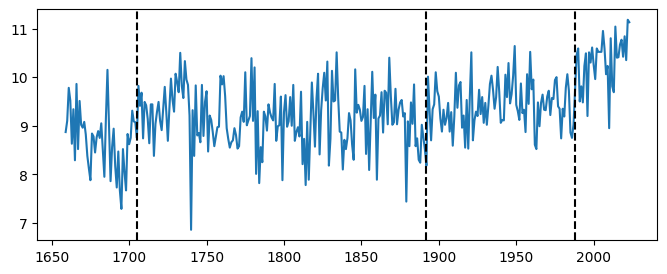

In [75]:
plt.figure(figsize=(8, 3))
Xcet = mtu[['Annual']][:-1].to_numpy(dtype=np.double)
years = mtu[['Year']][:-1].to_numpy(dtype=np.double)
plt.plot(years[:], Xcet[:])
[plt.axvline(df_dis['Location'][i], color='black', linestyle='--') for i in range(ncps)]

In [26]:
np.array(kern_cpd.fit_predict(Xcet, n_bkps = 3)[:-1])+1658

array([1701, 1910, 1987])

In [83]:
op = changeforest.changeforest(Xcet)
np.array(op.split_points())+1658

array([1982, 1988])